### Import Library
We are going to use pandas to easily control the flow of data to be used for analysis later on. Then to easily optimize our analysis we are going to use the analysis function from Scipy

In [23]:
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib as plt
import seaborn as sns
from scipy.linalg import cholesky, solve_triangular, cho_solve, cho_factor
from scipy.linalg import solve
from scipy.optimize import minimize

### Import Historical Stock Data
for this first prototype we are going to use strictly 3 stocks which is BBCA, ITMG, & MCAS

In [24]:
df_bbca = pd.read_csv('BBCA.JK.csv')
df_itmg = pd.read_csv('ITMG.JK.csv')
df_mcas = pd.read_csv('MCAS.JK.csv')
df_mvf  = pd.read_csv('Weight Ratio.csv')

In [25]:
# Filter the column that is used

df_bbca = df_bbca[['Date', 'Symbol', 'Close','Return+1']]
df_itmg = df_itmg[['Date', 'Symbol', 'Close','Return+1']]
df_mcas = df_mcas[['Date', 'Symbol', 'Close','Return+1']]

### Extract Risk and Return 
Geomean for Return calculation
Variance for Risk calculation

In [26]:
def geomeanReturn(df):
    geomean = (stats.gmean(df['Return+1'].iloc[2:-1])) - 1
    return geomean

bbca_geomean = geomeanReturn(df_bbca)
itmg_geomean = geomeanReturn(df_itmg)
mcas_geomean = geomeanReturn(df_mcas)

In [27]:
def varianceRisk(df):
    variance = df['Return+1'].iloc[2:-1].var()
    return variance

bbca_var = varianceRisk(df_bbca)
itmg_var = varianceRisk(df_itmg)
mcas_var = varianceRisk(df_mcas)


In [28]:
def covarStock(df1,df2):
    covar = np.cov(df1['Return+1'], df2['Return+1'])
    return covar[0][1]

cov_bbca_itmg = covarStock(df_bbca,df_itmg)
cov_bbca_mcas = covarStock(df_bbca,df_mcas)
cov_itmg_mcas = covarStock(df_itmg,df_mcas)

In [29]:
import random
def generateDist(n):
    arrN = [None] * n 
    arrX, arrY, arrZ = []  , [] , []
    for i in range(0,n):
        arrN[i] = random.randrange(100)

        x = arrN[i]
        arrX.append((x/100))

        y = random.randrange(100-arrN[i])
        arrY.append((y/100))

        z = 100 - x - y
        arrZ.append((z/100))
    df = pd.DataFrame(
    {'asset_1': arrX,
     'asset_2': arrY,
     'asset_3': arrZ
    })
    return df
df_dist = generateDist(100)

In [30]:
df_dist['a1square'] = df_dist.asset_1 ** 2
df_dist['a2square'] = df_dist.asset_2 ** 2
df_dist['a3square'] = df_dist.asset_3 ** 2

In [31]:
df_dist["risk"] = (df_dist.a1square * bbca_var) + (df_dist.a2square * itmg_var) + (df_dist.a3square * mcas_var) + (2*(df_dist.asset_1 * df_dist.asset_2 * cov_bbca_itmg)) + (2*(df_dist.asset_1 * df_dist.asset_3 * cov_bbca_mcas)) + (2*(df_dist.asset_3 * df_dist.asset_2 * cov_itmg_mcas))

In [32]:
df_dist["return"] = (df_dist.asset_1 * bbca_geomean) + (df_dist.asset_2 * itmg_geomean) + (df_dist.asset_3 * mcas_geomean)

In [33]:
minrisk = float(input())

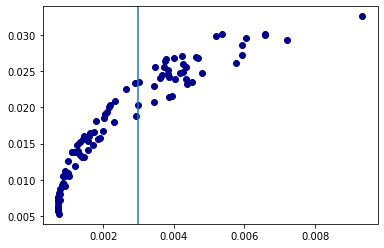

In [34]:
plt.pyplot.scatter(df_dist.risk, df_dist['return'], c="DarkBlue")
plt.pyplot.axvline(x = minrisk)

In [35]:
def f(x):
    return -(x[0]*bbca_geomean + x[1]*itmg_geomean + x[2] * mcas_geomean)

In [36]:
b = (0.0 , 1.0)
bnds = (b,b,b)

In [37]:
cons = ({'type': 'eq',
         'fun' : lambda x: np.array([x[0] + x[1] + x[2] - 1,
          ((x[0] * bbca_var) + (x[1] * itmg_var) + (x[2] * mcas_var) + 
          (2*(x[0] * x[1] * cov_bbca_itmg)) + (2*(x[0] * x[2] * cov_bbca_mcas)) + (2*(x[1] * x[2] * cov_itmg_mcas)) - minrisk)])})

In [38]:
x0 = np.array([df_dist.asset_1[0],df_dist.asset_2[0],df_dist.asset_3[0]])
res = minimize(f, x0, bounds = bnds, constraints=cons)

In [39]:
res.x

array([5.20194197e-01, 4.79805803e-01, 5.89805982e-16])

In [40]:
res.fun

-0.013347468991979828